In [1]:
import osmnx as ox #openstreet
import networkx as nx

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

import geopandas as gpd
import fiona
import shapely
from shapely.geometry import box
from shapely.geometry import shape
from shapely.geometry import LineString, Point

In [2]:
input_path = 'input'
output_path = 'output'

---------------


### get graph by place

In [3]:
def get_entire_graph_from_place(city, buffer_distance, epsg, output_path):
    
    place_name = f'{city}, Nederland'
    graph = ox.graph_from_place(place_name, network_type='drive', buffer_dist= buffer_distance)
    fig, ax = ox.plot_graph(graph)
    
    graph_proj = ox.project_graph(graph, to_crs=epsg)
    nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)
    print("Coordinate system:", edges_proj.crs)
    
    #stringify no numerics
    nodes_proj_stringify = ox.io._stringify_nonnumeric_cols(nodes_proj)
    edges_proj_stringify  = ox.io._stringify_nonnumeric_cols(edges_proj)

    # save graph nodes and edges to disk as GeoJSON
    nodes_proj_stringify.to_file(f'{output_path}/{city}_nodes_{epsg}ww.geojson', driver='GeoJSON')
    edges_proj_stringify.to_file(f'{output_path}/{city}_edges_{epsg}ww.geojson', driver='GeoJSON')
    
    return graph_proj

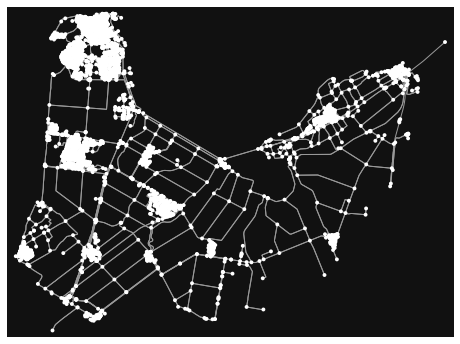

Coordinate system: epsg:28992


In [4]:
#execute
get_entire_graph_from_place('Den Helder', 10000, 28992, output_path)

---------------------

### get graph by shape

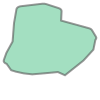

In [5]:
##via hhnk gebiedgrens
hhnk_gebied_path = f'{input_path}/extend_wgs.geojson'
hhnk_gdf = gpd.read_file(hhnk_gebied_path)
hhnk_geom = hhnk_gdf.geometry[0]
hhnk_geom

In [14]:
#get graph from polygon
multigraph_fromosm = ox.graph_from_polygon(
    hhnk_geom,
    network_type="drive",
    simplify = True, 
    custom_filter='["highway"~"primary|secondary|tertiary|secondary_link|tertiary_link|primary_link|unclassified" ]'
)
type(multigraph_fromosm)

networkx.classes.multidigraph.MultiDiGraph

In [15]:
multigraph_fromosm_proj= ox.project_graph(multigraph_fromosm)

In [16]:
def initialize_capacity_dry_roads(MultiGraph):
    c = {}

    #basic
    for e in MultiGraph.edges(data=True):
        if e[2]['highway'] == 'tertiary':
            e[2]['capacity'] = 1000
            c[(e[0], e[1])]  = 1000
        elif e[2]['highway'] == 'secondary_link':
            e[2]['capacity'] = 1400
            c[(e[0], e[1])]  = 1400
        elif e[2]['highway'] == 'secondary':
            e[2]['capacity'] = 1400
            c[(e[0], e[1])]  = 1400
        elif e[2]['highway'] == 'primary':
            e[2]['capacity'] = 1600
            c[(e[0], e[1])]  = 1600
        elif e[2]['highway'] == 'primary_link':
            e[2]['capacity'] = 1600
            c[(e[0], e[1])]  = 1600
        else: 
            e[2]['capacity'] = 9999 

    #floodepth naar zero 
    for e in MultiGraph.edges(data=True):
        e[2]['flooddepth'] = 0
    
    return MultiGraph, c


multigraph_fromosm_proj, capacities = initialize_capacity_dry_roads(MultiGraph= multigraph_fromosm_proj)

In [18]:
nodes_proj, edges_proj = ox.graph_to_gdfs(multigraph_fromosm_proj, nodes=True, edges=True)
print("Coordinate system:", edges_proj.crs)

## export
#stringify no numerics
nodes_proj_stringify = ox.io._stringify_nonnumeric_cols(nodes_proj)
edges_proj_stringify  = ox.io._stringify_nonnumeric_cols(edges_proj)

# save graph nodes and edges to disk as GeoJSON
nodes_proj_stringify.to_file(f'{output_path}/_nodes_initial_v2_alldrive.geojson', driver='GeoJSON',  crs= 'epsg:32631')
edges_proj_stringify.to_file(f'{output_path}/_edges_initial_v2_alldrive.geojson', driver='GeoJSON',  crs= 'epsg:32631')

Coordinate system: +proj=utm +zone=31 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


### get geometrie from place

In [10]:
def get_roadnetwork(city, buffer_distance, epsg, output_path):
    
    place_name = f'{city}, Nederland'
    
    roadnetwork_place = ox.geometries_from_place(place_name, buffer_dist= buffer_distance, tags= {
    'highway': True, 
    'network_type': 'drive', 
    'element_type': 'way'})
    
    roadnetwork_place_proj = ox.project_graph(roadnetwork_place, to_crs=epsg)
    
    #stringify no numerics
    roadnetwork_string = ox.io._stringify_nonnumeric_cols(roadnetwork_place)

    #safe to harddisk
    roadnetwork_string.to_file(f'{output_path}/{city}_road_network.geojson', driver='GeoJSON')





In [11]:
# ## convert it to a geodatafram
# edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

In [12]:
get_roadnetwork('Den Helder', 0, 28992, output_path)

AttributeError: 'GeoDataFrame' object has no attribute 'graph'

In [ ]:
roadnetwork_place = ox.geometries_from_place()

In [ ]:
    place_name = f'{city}, Nederland'
    
    roadnetwork_place = ox.geometries_from_place(place_name, tags= {
    'highway': True, 
    'network_type': 'drive', 
    'element_type': 'way'})

In [ ]:
 roadnetwork_place 